In [1]:
#from netgen import gui
from ngsolve.webgui import Draw
from ngsolve import *
from netgen.geom2d import SplineGeometry

In [6]:
from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
geo.AddRectangle( (0, 0), (2, 0.41), bcs = ("wall", "outlet", "wall", "inlet"))
geo.AddCircle ( (0.2, 0.2), r=0.05, leftdomain=0, rightdomain=1, bc="cyl")
mesh = Mesh( geo.GenerateMesh(maxh=0.1))
mesh.Curve(3) 
Draw(mesh)
# viscosity
nu = 0.001

In [7]:
k = 3
V = VectorH1(mesh,order=k, dirichlet="wall|cyl|inlet")
Q = H1(mesh,order=k-1)
X = FESpace([V,Q])

In [8]:
gfu = GridFunction(X)
velocity = gfu.components[0]
Draw(velocity,mesh,"u",sd=3)
Draw(gfu.components[1],mesh,"p",sd=3)
from ngsolve.internal import visoptions
visoptions.scalfunction = "u:0"

# parabolic inflow at bc=1:
uin = CoefficientFunction((1.5*4*y*(0.41-y)/(0.41*0.41),0))
gfu.components[0].Set(uin, definedon=mesh.Boundaries("inlet"))

Redraw()

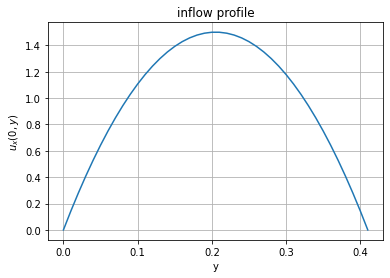

In [9]:
import matplotlib; import numpy as np; import matplotlib.pyplot as plt;
%matplotlib inline
s = np.arange(0.0, 0.42, 0.01)
bvs = 6*s*(0.41-s)/(0.41)**2
plt.plot(s, bvs)
plt.xlabel('y'); plt.ylabel('$u_x(0,y)$'); plt.title('inflow profile')
plt.grid(True)
plt.show()

In [10]:
(u,p), (v,q) = X.TnT()

a = BilinearForm(X)
stokes = (nu*InnerProduct(grad(u),grad(v))-div(u)*q-div(v)*p)*dx
a += stokes
a.Assemble()

f = LinearForm(X)
f.Assemble()

inv_stokes = a.mat.Inverse(X.FreeDofs())

res = f.vec.CreateVector()
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += inv_stokes * res

Redraw()

In [11]:
import scipy.sparse as sp
dt = 0.1
# matrix for implicit part of IMEX(1) scheme:
mstar = BilinearForm(X)
mstar += InnerProduct(u,v)*dx + dt*stokes
mstar.Assemble()

rows,cols,vals = mstar.mat.COO()
mstar_sp = sp.csr_matrix((vals,(rows,cols)))
inv = mstar.mat.Inverse(X.FreeDofs())

conv = LinearForm(X)
conv += InnerProduct(grad(velocity)*velocity,v)*dx

In [12]:
print(mstar_sp.shape[1])
import numpy as np
tmp_A = mstar_sp.todense()

for i in range(20):
    V, r = np.linalg.qr(tmp_A)
    tmp_B = r.dot(V)
    if i > 0:
        tmp_diag = tmp_B/tmp_A
    tmp_A = tmp_B
    print(i)
#from scipy.sparse.linalg import eigs
#vals, vecs = eigs(mstar_sp, k=mstar_sp.shape[1]-2)
#vals
print(V)

2983
0


/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


1
2
3


KeyboardInterrupt: 

In [9]:
#print(np.diag(tmp_diag))
#print(np.diag(tmp_A.max))
print(np.amax(np.diag(tmp_A)))

0.014375194902294297


In [10]:
t = 0
tend = 0

# implicit Euler/explicit Euler splitting method:
tend += 1
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    res.data = a.mat * gfu.vec + conv.vec
    gfu.vec.data -= dt * inv * res

    t = t + dt
    Redraw()




t= 0.8999999999999999